In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model, model_from_json
import keras.utils as ku 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tokenizer = Tokenizer(char_level=True)

Using TensorFlow backend.


In [1]:
c_len=22
fname = './data/pdb_seqres.txt'

In [40]:
def dataset_preparation(fname):
    data = open(fname).read()

    # basic cleanup
    #corpus = data.split("\n")
    corpus1 = data.split("\n")
    corpus = corpus1[::44]
    #print(corpus)
    for i in range(len(corpus)):
        if (len(corpus[i])>c_len):
            corpus[i]=corpus[i][:c_len]
        else:
            continue
    # tokenization	
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1

    # create input sequences using list of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    # pad sequences 
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    # create predictors and label
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)

    return predictors, label, max_sequence_len, total_words

def create_model(predictors, label, max_sequence_len, total_words):
    index_train = np.array([True]*len(predictors))
    index_train[ np.arange(5,len(predictors),5)] = False
    index_test = ~index_train
    x_train = predictors[index_train]
    y_train = label[index_train]
    x_test = predictors[index_test]
    y_test = label[index_test]
    
    model = Sequential()
    model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
    model.add(LSTM(150, return_sequences = True))
    # model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

    #     model.fit(predictors, label, epochs=100, verbose=1, callbacks=[earlystop])
    history = model.fit(x_train, y_train, epochs=7, verbose=1, validation_data=(x_test, y_test), callbacks=[earlystop])
    print(model.summary())
    return history, model 

def generate_amino(protein, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([protein])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)

    next_amino = ""
    for amino, index in tokenizer.word_index.items():
        if index == predicted:
            next_amino = amino
            break
#     Tokens are the same for lowe nad upper cases
    next_amino = next_amino.upper()   
    new_protein = protein + next_amino
    return new_protein, next_amino

In [41]:
# The full set
# fname = '/home/grzegorz/Desktop/CNN_pr2/data/pdb_seqres.txt'
# The small set only for testing
#fname = '/home/grzegorz/Desktop/CNN_pr2/data/pdb_test.txt'

predictors, label, max_sequence_len, total_words = dataset_preparation(fname=fname)

In [2]:
#print(predictors.shape)
#print(label.shape)
#print(max_sequence_len)
#print(total_words)

In [42]:
history, model = create_model(predictors, label, max_sequence_len, total_words)

Train on 163455 samples, validate on 40863 samples
Epoch 1/7
163455/163455 [==============================] - 612s 4ms/step - loss: 2.7628 - acc: 0.1278 - val_loss: 2.7032 - val_acc: 0.1501
Epoch 2/7
163455/163455 [==============================] - 598s 4ms/step - loss: 2.6612 - acc: 0.1647 - val_loss: 2.6144 - val_acc: 0.1839
Epoch 3/7
163455/163455 [==============================] - 599s 4ms/step - loss: 2.5730 - acc: 0.1973 - val_loss: 2.5486 - val_acc: 0.2114
Epoch 4/7
163455/163455 [==============================] - 599s 4ms/step - loss: 2.4879 - acc: 0.2291 - val_loss: 2.4758 - val_acc: 0.2348
Epoch 5/7
163455/163455 [==============================] - 597s 4ms/step - loss: 2.3929 - acc: 0.2627 - val_loss: 2.4129 - val_acc: 0.2629
Epoch 6/7
163455/163455 [==============================] - 596s 4ms/step - loss: 2.3005 - acc: 0.2958 - val_loss: 2.3679 - val_acc: 0.2827
Epoch 7/7
163455/163455 [==============================] - 596s 4ms/step - loss: 2.2200 - acc: 0.3231 - val_loss: 2

In [46]:
#model_json = model.to_json()
#with open("model_updated.json", "w") as json_file:
#    json_file.write(model_json)
# # serialize weights to HDF5
#model.save_weights("model_updated.h5")
#model = load_model('model_updated.h5')
#model = model_from_json('model_updated.json')
#print("Saved model to disk")

In [44]:

# load json and create model
json_file = open('model_updated.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_updated.h5")
print("Loaded model from disk")

Loaded model from disk


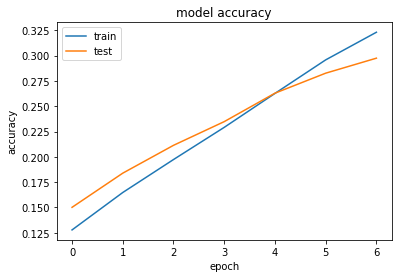

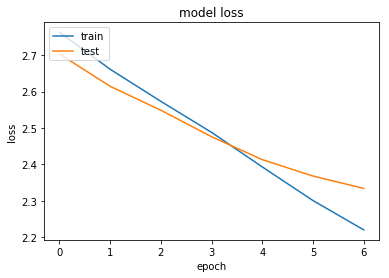

In [68]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_updated.jpg')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_updated.jpg')
plt.show()

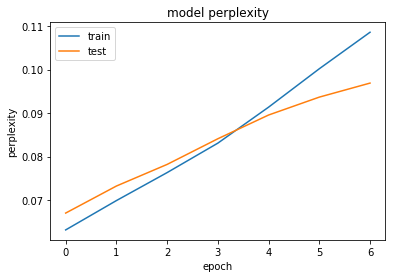

In [69]:
#print(history.history['loss'])
exp_negative_loss_train=list(np.exp(np.negative(history.history['loss'])))
#print(exp_negative_loss_train)
#print(history.history['val_loss'])
exp_negative_loss_test=list(np.exp(np.negative(history.history['val_loss'])))
#print(exp_negative_loss_test)

plt.plot(exp_negative_loss_train)
plt.plot(exp_negative_loss_test)
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('perplexity.jpg')
plt.show()

In [72]:
# perplexity = (step * 1.0 / model.input.epoch_size, np.exp(costs / iters)
# index_train = np.array([True]*len(predictors))
# index_train[ np.arange(5,len(predictors),5)] = False
# index_test = ~index_train
# x_train = predictors[index_train]
# y_train = label[index_train]
# x_test = predictors[index_test]
# y_test = label[index_test]


#data = open(fname).read()
#proteins = data.split("\n")
data = open(fname).read()
corpus1 = data.split("\n")
proteins = corpus1[::44]
#print(corpus)
for i in range(len(proteins)):
    if (len(proteins[i])>c_len):
        proteins[i]=proteins[i][:c_len]
    else:
        continue
print(proteins[:5])

['MVLSEGEWQLVLHVWAKVEADV', 'MNIFEMLRIDEGLRLKIYKDTE', 'MNIFEILRIDEGLRLKIYKDTE', 'MNIFEMLRIDEGLRLKIYKDTE', 'MKAERKRMRNRIAASKSRKRKL']


In [79]:
# Task III – Sequence Generation Techniques
# EXAMPLE 1
i = 0
new_protein = proteins[i][:5]
print(proteins[i][:19])
while len(new_protein)<19:
    new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
    print(new_protein)
    #print(next_amino)

MVLSEGEWQLVLHVWAKVE
MVLSER
MVLSERS
MVLSERSV
MVLSERSVT
MVLSERSVTA
MVLSERSVTAA
MVLSERSVTAAK
MVLSERSVTAAKK
MVLSERSVTAAKKG
MVLSERSVTAAKKGY
MVLSERSVTAAKKGYG
MVLSERSVTAAKKGYGE
MVLSERSVTAAKKGYGEV
MVLSERSVTAAKKGYGEVG


In [80]:
# EXAMPLE 2
i = 10
new_protein = proteins[i][:5]
print(proteins[i][:19])
while len(new_protein)<19:
    new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
    print(new_protein)

SKSHSEAGSAFIQTQQLHA
SKSHSH
SKSHSHH
SKSHSHHH
SKSHSHHHH
SKSHSHHHHH
SKSHSHHHHHH
SKSHSHHHHHHA
SKSHSHHHHHHAE
SKSHSHHHHHHAEE
SKSHSHHHHHHAEEE
SKSHSHHHHHHAEEEE
SKSHSHHHHHHAEEEEE
SKSHSHHHHHHAEEEEEF
SKSHSHHHHHHAEEEEEFV


In [81]:
# EXAMPLE 3
i = 20
new_protein = proteins[i][:5]
print(proteins[i][:19])
while len(new_protein)<19:
    new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
    print(new_protein)

FPRGGGGGNGDFEEIPEEY
FPRGGK
FPRGGKR
FPRGGKRP
FPRGGKRPV
FPRGGKRPVI
FPRGGKRPVIV
FPRGGKRPVIVG
FPRGGKRPVIVGG
FPRGGKRPVIVGGG
FPRGGKRPVIVGGGG
FPRGGKRPVIVGGGGG
FPRGGKRPVIVGGGGGG
FPRGGKRPVIVGGGGGGG
FPRGGKRPVIVGGGGGGGG


In [82]:
# EXAMPLE 4
i = 40
new_protein = proteins[i][:5]
print(proteins[i][:19])
while len(new_protein)<19:
    new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
    print(new_protein)

GCTLSAEDKAAVERSKMID
GCTLSL
GCTLSLL
GCTLSLLA
GCTLSLLAV
GCTLSLLAVG
GCTLSLLAVGL
GCTLSLLAVGLG
GCTLSLLAVGLGG
GCTLSLLAVGLGGG
GCTLSLLAVGLGGGG
GCTLSLLAVGLGGGGG
GCTLSLLAVGLGGGGGA
GCTLSLLAVGLGGGGGAG
GCTLSLLAVGLGGGGGAGV


In [83]:
# EXAMPLE 5
i = 50
new_protein = proteins[i][:5]
print(proteins[i][:19])
while len(new_protein)<19:
    new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
    print(new_protein)

LFLAQEIIRKKRDGHALSD
LFLAQA
LFLAQAG
LFLAQAGG
LFLAQAGGQ
LFLAQAGGQL
LFLAQAGGQLG
LFLAQAGGQLGR
LFLAQAGGQLGRR
LFLAQAGGQLGRRG
LFLAQAGGQLGRRGS
LFLAQAGGQLGRRGSM
LFLAQAGGQLGRRGSMD
LFLAQAGGQLGRRGSMDV
LFLAQAGGQLGRRGSMDVV


In [85]:
index_train = np.array([True]*len(proteins))
index_train[ np.arange(5,len(proteins),5)] = False
index_test = ~index_train
proteins = np.array(proteins)
protein_test = proteins[index_test]

In [3]:
#print(index_train)
#print(index_test)

In [90]:
def compare_proteins(correct_protein,new_protein, i):
    pred_cor = list()
    for x, y in zip(seq_cor,new_protein):
        if x == y:
            pred_cor.append(1)
        else:
            pred_cor.append(0)
    pred_cor = np.array(pred_cor)        
    pred_cor[:i]=0
    pred = list()
    s = 0
    for i in pred_cor:
        s = s + i
        pred.append(s)
    pred = np.array(pred)
    return pred

In [91]:
res_mat_glob = list()
for pr in protein_test:
    res_mat_loc = list()
    for i in range(1,20):
        seq_cor = pr[:19]
        seq = pr[:i]
        new_protein = seq
        while len(new_protein)<19:
            new_protein, next_amino = generate_amino(new_protein, max_sequence_len)
        res = compare_proteins(seq_cor,new_protein, i)
        res_mat_loc.append(res)
    res_mat_loc = np.array(res_mat_loc)
    res_mat_glob.append(res_mat_loc)
    print(res_mat_loc.shape)
    print(res_mat_loc)
    

(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 4 4 5 6 7 8 8]
 [0 0 1 2 2 2 2 2 2 2 2 2 3 3 4 5 6 7 7]
 [0 0 0 1 1 1 1 1 1 1 1 1 2 2 3 4 5 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4 5 5]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 3 4 4 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 4 4]
 [0 0 0 0 0 0 0 1 2 3 4 5 6 7 8 9 9 9 9]
 [0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 8 8 8 8]
 [0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 7 7 7]
 [0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 

(19, 19)
[[ 0  1  1  2  2  2  3  4  5  5  6  7  7  8  8  8  8  8  8]
 [ 0  0  0  1  1  1  2  3  4  4  5  6  6  7  7  7  7  7  7]
 [ 0  0  0  1  2  3  4  5  5  6  7  8  9 10 10 10 10 11 11]
 [ 0  0  0  0  1  2  3  4  4  5  6  7  8  9  9  9  9 10 10]
 [ 0  0  0  0  0  1  2  3  3  4  5  6  7  8  8  8  8  9  9]
 [ 0  0  0  0  0  0  1  2  2  3  4  5  6  7  7  7  7  8  8]
 [ 0  0  0  0  0  0  0  1  1  2  3  4  5  6  6  6  6  7  7]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  5  5  5  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 1 2 2 3 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4 5 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 1 2 2 2 3 4 4 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 1 1 1 2 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

(19, 19)
[[ 0  1  2  2  3  4  5  6  6  6  7  8  9  9  9 10 10 10 11]
 [ 0  0  1  1  2  3  4  5  5  5  6  7  8  8  8  9  9  9 10]
 [ 0  0  0  0  1  2  3  4  4  4  5  6  7  7  7  8  8  8  9]
 [ 0  0  0  0  1  2  3  4  5  5  6  7  8  8  9 10 10 10 11]
 [ 0  0  0  0  0  1  2  3  4  4  5  6  7  7  8  9  9  9 10]
 [ 0  0  0  0  0  0  1  2  3  3  4  5  6  6  7  8  8  8  9]
 [ 0  0  0  0  0  0  0  1  2  2  3  4  5  5  6  7  7  7  8]
 [ 0  0  0  0  0  0  0  0  1  1  2  3  4  4  5  6  6  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5  5  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 1 2 3 4 5 6 6 7 8 8 8 9 9 9 9 9 9]
 [0 0 0 1 2 3 4 5 5 6 7 7 7 8 8 8 8 8 8]
 [0 0 0 0 1 2 3 4 4 5 6 6 6 7 7 7 7 7 7]
 [0 0 0 0 0 1 2 3 3 4 5 5 5 6 6 6 6 6 6]
 [0 0 0 0 0 0 1 2 2 3 4 4 4 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 1 1 2 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 2 2 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 2 2 3 3 3 3 4 5 5 5 5 5 5 6]
 [0 0 0 0 0 1 1 2 2 2 2 3 4 4 4 4 4 4 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3 3 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 

(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 2 3 3 3 4 4 5 6 7 8 9]
 [0 0 0 0 0 0 0 0 1 2 2 2 3 3 4 5 6 7 8]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 4 5 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 2 3 4 4 4 4 5 6 6 6]
 [0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 4 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 3 4 5 5 5 5 5 5 5 5 5 5 6 7 7]
 [0 0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 5 6 6]
 [0 0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 4 5 5]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 3 4 4]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 2 3 3 3 3 3 3 3 3 4 4 5 5 5 5 5]
 [0 0 0 1 2 2 2 2 2 2 2 2 3 3 4 4 4 4 4]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 

(19, 19)
[[0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

(19, 19)
[[0 0 0 0 1 2 3 4 4 4 5 5 5 5 5 6 6 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 1 2 3 4 5 5 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 3 

(19, 19)
[[ 0  0  1  1  1  1  1  1  2  2  3  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  2  2  2  2]
 [ 0  0  0  0  1  2  3  4  4  5  6  7  8  9 10 11 11 12 13]
 [ 0  0  0  0  0  1  2  3  3  4  5  6  7  8  9 10 10 11 12]
 [ 0  0  0  0  0  0  1  2  2  3  4  5  6  7  8  9  9 10 11]
 [ 0  0  0  0  0  0  0  1  1  2  3  4  5  6  7  8  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 2 3 3 3 3 3 3 4 4 4 4 4 5]
 [0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 3 4 5 6 7 7 8 9 9 9]
 [0 0 0 0 0 0 0 0 1 2 3 4 5 6 6 7 8 8 8]
 [0 0 0 0 0 0 0 0 0 1 2 3 4 5 5 6 7 7 7]
 [0 0 0 0 0 0 0 0 0 0 1 2 3 4 4 5 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 4 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 3 4 5 5 6 6]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 2 3 4 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 10 10 10 10 10 10 10]
 [ 0  0  0  1  2  3  4  5  6  7  8  9  9  9  9  9  9  9  9]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  8  8  8  8  8  8  8]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  7  7  7  7  7  7  7]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  6  6  6  6  6  6  6]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  5  5  5  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 2 3 4 4 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 1 2 3 4 5 5 6 6 6 6 6 6 6 6 6 6]
 [0 0 0 0 1 2 3 4 4 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 1 2 3 3 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 1 2 2 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 1 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 2 3 3 4 5 5 5 5 5 5 5 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 3 4 5 5 6 6 6 6 6 6 6 6 6 6 6]
 [0 0 0 1 2 3 4 4 5 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 1 2 3 3 4 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 1 2 2 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1]
 [ 0  0  1  2  3  4  5  6  7  8  9  9  9  9  9 10 10 10 10]
 [ 0  0  0  1  2  3  4  5  6  7  8  8  8  8  8  9  9  9  9]
 [ 0  0  0  0  1  2  3  4  5  6  7  7  7  7  7  8  8  8  8]
 [ 0  0  0  0  0  1  2  3  4  5  6  6  6  6  6  7  7  7  7]
 [ 0  0  0  0  0  0  1  2  3  4  5  5  5  5  5  6  6  6  6]
 [ 0  0  0  0  0  0  0  1  2  3  4  4  4  4  4  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  1  2  3  3  3  3  3  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  1  2  2  2  2  2  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 

(19, 19)
[[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 4]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  2  3]
 [ 0  0  0  0  0  1  2  2  3  3  3  3  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 2 2 3 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  1  1  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 2 3 3 3 4 4 4 4 4 4 4 4 4 4 4 5]
 [0 0 0 1 2 2 2 3 3 3 3 3 3 3 3 3 3 3 4]
 [0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 3]
 [0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3 3 4 4]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 5 5 6]
 [0 0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 4 4 5]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 4]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4]
 [0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2]
 [0 0 1 2 2 2 3 3 3 4 4 5 5 5 5 5 5 5 5]
 [0 0 0 1 1 1 2 2 2 3 3 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 1 1 1 2 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 2 2 2 2 2 2 3 3 4 4 4 4 4 4 4 4 4]
 [0 0 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  2  3  4  5  6  6  7  8  9 10 10 11 11 12 12]
 [ 0  0  0  0  1  2  3  4  5  5  6  7  8  9  9 10 10 11 11]
 [ 0  0  0  0  0  1  2  3  4  4  5  6  7  8  8  9  9 10 10]
 [ 0  0  0  0  0  0  1  2  3  3  4  5  6  7  7  8  8  9  9]
 [ 0  0  0  0  0  0  0  1  2  2  3  4  5  6  6  7  7  8  8]
 [ 0  0  0  0  0  0  0  0  1  1  2  3  4  5  5  6  6  7  7]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  5  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 

(19, 19)
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  1  2  2  3  3  3  3  3  3  4  4  5  5  5]
 [ 0  0  0  0  1  1  1  1  1  1  1  2  2  2  2  2  2  2  3]
 [ 0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  1  1  1  2  3  4  4  5  6  7  8  8  9 10 10]
 [ 0  0  0  0  0  0  0  1  2  3  3  4  5  6  7  7  8  9  9]
 [ 0  0  0  0  0  0  0  1  2  3  3  4  5  6  6  6  6  6  6]
 [ 0  0  0  0  0  0  0  1  2  3  3  4  4  5  6  6  6  6  7]
 [ 0  0  0  0  0  0  0  0  1  2  2  3  3  4  5  5  5  5  6]
 [ 0  0  0  0  0  0  0  0  0  1  1  2  2  3  4  4  4  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 11 11 11 11 11 11]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 10 10 10 10 10 10]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9  9  9  9  9  9  9]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  8  8  8  8  8  8]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  7  7  7  7  7  7]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  6  6  6  6  6  6]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  5  5  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  4  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 2 3 3 4 4 4 4 5 5 5 5]
 [0 0 0 0 0 0 1 1 2 3 3 4 4 4 4 5 5 5 5]
 [0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 2 2 2 2 3 3 3 3 3 4 4 4]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 2 3 4 5 6 7 8 8 8 8 8 8 8 8]
 [0 0 0 0 0 1 2 3 4 5 6 7 7 7 7 7 7 7 

(19, 19)
[[ 0  0  0  0  1  1  2  2  2  3  3  3  3  3  3  3  3  3  4]
 [ 0  0  0  1  1  1  2  2  2  3  3  3  3  3  3  3  3  3  3]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 3 3 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 1 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 3 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6]
 [0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5]
 [0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4]
 [0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 

(19, 19)
[[ 0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  1  1  1  1  2  3  3  3  3  3  3  3  4  4  4]
 [ 0  0  0  0  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 

(19, 19)
[[0 1 1 1 2 2 3 3 3 3 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 1 1 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 1 2 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3]
 [0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 2 2 2 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  2  2  2]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 3 3]
 [0 0 0 1 2 3 4 4 4 4 4 4 4 5 5 5 5 5 5]
 [0 0 0 0 1 2 3 3 3 3 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 3 3 3]
 [0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 3 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 2 3 3 3 3 3 3]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 2 2 2 2 3 3 3 4 4 4 4 4]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 4]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  2  2  2  2  2]
 [ 0  0  1  2  3  4  4  5  6  7  8  9 10 10 11 12 13 14 15]
 [ 0  0  0  1  2  3  3  4  5  6  7  8  9  9 10 11 12 13 14]
 [ 0  0  0  0  1  2  2

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 3 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 1 2 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 1 2 3 4 4 4 4 4 4 4 4 4 5 5 5 5 5 6]
 [0 0 1 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 5]
 [0 0 0 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 4]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 1 1 2 2 3 3 3 3 3 3 4 4 4 5 5 5]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 3 3 3 4 4 4]
 [0 0 0 0 0 1 2 3 4 5 5 6 7 8 8 8 9 9 9]
 [0 0 0 0 0 0 1 2 3 4 4 5 6 7 7 7 8 8 8]
 [0 0 0 0 0 0 0 1 2 3 3 4 5 6 6 6 7 7 7]
 [0 0 0 0 0 0 0 0 1 2 2 3 4 5 5 5 6 6 6]
 [0 0 0 0 0 0 0 0 0 1 1 2 3 4 4 4 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 3 4 5 5 5 5 5 6 6 6 6]
 [0 0 0 0 0 0 0 1 2 3 4 4 4 4 4 5 5 5 5]
 [0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 1 2 3 4 5 6 6 7 8 8 8 9 9 9 9 9 9]
 [0 0 0 1 2 3 4 5 5 6 7 7 7 8 8 8 8 8 8]
 [0 0 0 0 1 2 3 4 4 5 6 6 6 7 7 7 7 7 7]
 [0 0 0 0 0 1 2 3 3 4 5 5 5 6 6 6 6 6 6]
 [0 0 0 0 0 0 1 2 2 3 4 4 4 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 1 1 2 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  2  2  2  2  2]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 

(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 1 2 3 4 4 4 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 1 2 3 4 4 4 5 5 5 6 6 7 7 7 7 7]
 [0 0 0 0 1 2 3 3 3 4 4 4 5 5 6 6 6 6 6]
 [0 0 0 0 0 1 2 2 2 3 3 3 4 4 5 5 5 5 5]
 [0 0 0 0 0 0 1 1 1 2 2 2 3 3 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 1 1 1 1 1 2 2 2 3 3 3 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 1 1 1 2 2 2 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 4 5 5]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 3 4 4 5 6 7 8 9 9 9 9 9 9 9 9]
 [0 0 0 1 2 3 3 4 5 6 7 8 8 8 8 8 8 8 8]
 [0 0 0 0 1 2 2 3 4 5 6 7 7 7 7 7 7 7 7]
 [0 0 0 0 0 1 1 2 3 4 5 6 6 6 6 6 6 6 6]
 [0 0 0 0 0 0 0 1 2 3 4 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  1  1  1  2  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 3 3 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  2  3  3  4  5  6  7  8  9 10 11 12 13 13 13 14 14]
 [ 0  0  1  2  2  3  4  5  6  7  8  9 10 11 12 12 12 13 13]
 [ 0  0  0  1  1  2  3  4  5  6  7  8  9 10 11 11 11 12 12]
 [ 0  0  0  0  0  1  2

(19, 19)
[[ 0  1  1  2  2  2  2  2  3  3  4  5  5  5  5  5  5  5  5]
 [ 0  0  0  1  1  1  1  1  2  2  3  4  4  4  4  4  4  4  4]
 [ 0  0  0  1  1  1  1  1  2  3  4  5  5  5  5  5  6  6  6]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  4  4  4  4  5  5  5]
 [ 0  0  0  0  0  1  2  3  4  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  1  2  3  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  1  2  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  1  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 2 3 4 5 5 6 6 6 7 7 7 8]
 [0 0 0 0 0 0 0 1 2 3 4 4 5 5 5 6 6 6 7]
 [0 0 0 0 0 0 0 0 1 2 3 3 4 4 4 5 5 5 6]
 [0 0 0 0 0 0 0 0 0 1 2 2 3 3 3 4 4 4 5]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 1 2 3 4 5 6 7 7 8 8 8 8 9 9 9 9]
 [0 0 0 0 1 2 3 4 5 6 6 7 7 7 7 8 8 8 8]
 [0 0 0 0 0 1 2 3 4 5 5 6 6 6 6 7 7 7 7]
 [0 0 0 0 0 0 1 2 3 4 4 5 5 5 5 6 6 6 6]
 [0 0 0 0 0 0 0 1 2 3 3 4 4 4 4 5 5 5 5]
 [0 0 0 0 0 0 0 0 1 2 2 3 3 3 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 7 7]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  1  1  1  2  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  1  1  1  1  1  1  1  2  2  2  2  2  2  2]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  1  1  1  2  2  2  2  2  2  2  2  2  3  3  4]
 [ 0  0  0  1  2  2  2  3  3  3  3  4  4  4  4  4  4  4  4]
 [ 0  0  0  0  1  1  1  2  2  2  2  3  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  1  1  1  1  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 3 3 

(19, 19)
[[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3  4  5  6  7  7  8  9 10 10 10 11 11]
 [ 0  0  0  0  0  1  2  3  4  5  6  6  7  8  9  9  9 10 10]
 [ 0  0  0  0  0  0  1  2  3  4  5  5  6  7  8  8  8  9  9]
 [ 0  0  0  0  0  0  0  1  2  3  4  4  5  6  7  7  7  8  8]
 [ 0  0  0  0  0  0  0  0  1  2  3  3  4  5  6  6  6  7  7]
 [ 0  0  0  0  0  0  0  0  0  1  2  2  3  4  5  5  5  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  4  4  4  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  3  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 13 13 13 13]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 12 12 12 12]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 11 11 11 11]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 10 10 10 10]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9  9  9  9  9]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  8  8  8  8]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  7  7  7  7]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  6  6  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  2  3  4  5  5  6  6  7  8  9 10 10 10 11 11 11 11]
 [ 0  0  1  2  3  4  4  5  5  6  7  8  9  9  9 10 10 10 10]
 [ 0  0  0  1  2  3  3  4  4  5  6  7  8  8  8  9  9  9  9]
 [ 0  0  0  0  1  2  2

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  2  2  3  3]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  2  2  2  2]
 [ 0  0  0  0  0  0  0

(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 2 3 3 3 4 4 4 5 5 5 6]
 [0 0 0 0 0 0 0 0 1 2 2 2 3 3 3 4 4 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 

(19, 19)
[[0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 2 2 3 3 3 3 4 4 4 4 4 4 

(19, 19)
[[0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 2 3 3 3 4 4 5 5 5 5 5 5 5 6 6 6]
 [0 0 0 1 2 2 2 3 3 4 4 4 4 4 4 4 5 5 5]
 [0 0 0 0 1 1 1 2 2 3 3 3 3 3 3 3 4 4 4]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 3 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  2  2]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 1 1 2 2 2 2 2 3 3 3 3 3 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 3 4 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [0 0 0 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3

(19, 19)
[[ 0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  1  2  3  4  4  5  6  6  6  7  8  8  9 10 10 11 11 11]
 [ 0  0  1  2  3  3  4  5  5  5  6  7  7  8  9  9 10 10 10]
 [ 0  0  0  1  2  2  3  4  4  4  5  6  6  7  8  8  9  9  9]
 [ 0  0  0  0  1  1  2  3  3  3  4  5  5  6  7  7  8  8  8]
 [ 0  0  0  0  0  0  1  2  2  2  3  4  4  5  6  6  7  7  7]
 [ 0  0  0  0  0  0  1  2  2  3  4  5  5  6  6  6  6  7  7]
 [ 0  0  0  0  0  0  0  1  1  2  3  4  4  5  5  5  5  6  6]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  3  4  4  4  4  5  5]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 2 2 3 3 3 3 3 3 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  1  2  3  4  5  6  7  8  8  9 10 11 12 13 13 13]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 1 1 1 1 1 1 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 2 3 3 4 5 5 5 5 5 5 

(19, 19)
[[ 0  1  2  3  3  4  5  6  7  7  8  9  9 10 10 10 11 11 11]
 [ 0  0  1  2  2  3  4  5  6  6  7  8  8  9  9  9 10 10 10]
 [ 0  0  0  1  1  2  3  4  5  5  6  7  7  8  8  8  9  9  9]
 [ 0  0  0  0  0  1  2  3  4  4  5  6  6  7  7  7  8  8  8]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  6  7  8  9  9 10 11]
 [ 0  0  0  0  0  0  0  1  2  2  3  4  4  5  5  5  6  6  6]
 [ 0  0  0  0  0  0  0  1  2  2  3  4  4  5  5  5  6  6  6]
 [ 0  0  0  0  0  0  0  0  1  1  2  3  3  4  4  4  5  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  2  3  3  3  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  2  2  3  3]
 [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  8  9 10 10 10 10]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  7  8  9  9  9  9]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  6  7  8  8  8  8]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  5  6  7  7  7  7]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  4  5  6  6  6  6]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  3  4  5  5  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  2  3  4  4  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 

(19, 19)
[[ 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  1  1  1  1  2  2  2  2  2  3  3  3  3  4  4  4  4]
 [ 0  0  0  0  0  0  1  1  1  1  1  2  2  2  2  3  3  3  3]
 [ 0  0  0  0  1  1  2  2  2  2  2  3  3  3  3  3  3  3  3]
 [ 0  0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 2 2 3 3 4 4 4 4 4 5]
 [0 0 0 0 0 0 0 1 2 3 3 4 4 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 1 2 3 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  1  2  3  4  5  6  7  8  8  9 10 11 12 13 13 13]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 2 3 4 5 6 7 8 9 9 9 9 9 9 9 9]
 [0 0 0 0 1 2 3 4 5 6 7 8 8 8 8 8 8 8 8]
 [0 0 0 0 0 1 2 3 4 5 6 7 7 7 7 7 7 7 7]
 [0 0 0 0 0 0 1 2 3 4 5 6 6 6 6 6 6 6 6]
 [0 0 0 0 0 0 0 1 2 3 4 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 0 1 2 3 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 2 3 4 5 5 5 5 6 6 6 6 6 6 6 6 6]
 [0 0 0 1 2 3 4 4 4 4 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 1 2 3 3 3 3 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 1 2 2 2 2 3 3 3 3 3 3 3 3 

(19, 19)
[[0 0 1 2 2 2 3 4 4 4 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 1 1 1 1 1 1 2 3 4 4 4 4 4]
 [0 0 0 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 2 3 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 2 2 3 3 3 3 3 3 3 3 3 3 3 4 4]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 3 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 4 5 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 1 2 2 2 2 2 2 2 2 3 3 3 3 3 4 4 5 5]
 [0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4]
 [0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1]
 [ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 2 2 2 2 2 2 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 1 1 1 1 1 1 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 2 2 2 3 3 3 3 3]
 [0 0 0 1 2 3 3 3 3 3 4 4 4 4 4 4 4 4 4]
 [0 0 0 0 1 2 2 2 2 2 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 2 3 4 5 5 6 7 8 9 9]
 [0 0 0 0 0 0 0 0 0 1 2 3 4 4 5 6 7 8 8]
 [0 0 0 0 0 0 0 0 0 0 1 2 3 3 4 5 6 7 7]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 4 5 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3 4 5 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 

(19, 19)
[[0 1 2 2 2 2 2 2 2 2 2 2 2 3 3 4 4 4 4]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 2 3 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 1 2 2 3 3 3 3 4 4 4 4 5 5 5 5 5 5]
 [0 0 0 1 1 2 2 2 2 3 3 3 3 4 4 4 4 4 4]
 [0 0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 3 4 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 2 2 2 2 2 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 5 5 5]
 [0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 4 4 4]
 [0 0 0 1 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2]
 [0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3]
 [0 0 0 0 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 2 3 3 3 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 1 2 2 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  2  3  4  5  6  6  7  8  9 10 10 11 11 12 12 13 13]
 [ 0  0  1  2  3  4  5  5  6  7  8  9  9 10 10 11 11 12 12]
 [ 0  0  0  1  2  3  4  4  5  6  7  8  8  9  9 10 10 11 11]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 3 4 4 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

(19, 19)
[[0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 2 3 4 5 6 7 8 9 9 9 9 9 9 9 9]
 [0 0 0 0 1 2 3 4 5 6 7 8 8 8 8 8 8 8 8]
 [0 0 0 0 0 1 2 3 4 5 6 7 7 7 7 7 7 7 7]
 [0 0 0 0 0 0 1 2 3 4 5 6 6 6 6 6 6 6 6]
 [0 0 0 0 0 0 0 1 2 3 4 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 0 0 1 2 3 4 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 0 0 0 1 2 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 19)
[[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3

(19, 19)
[[0 0 0 0 1 1 1 1 1 1 1 1 2 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 3 3]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 9)
[[0 0 1 1 1 1 1 1 1]
 [0 0 1 1 1 2 2 2 2]
 [0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 

(19, 11)
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]
(19, 4)
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
(19, 16)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 

(19, 14)
[[ 0  0  0  0  1  1  1  1  1  1  1  1  1  1]
 [ 0  0  1  2  3  4  5  6  7  8  8  9 10 11]
 [ 0  0  0  1  2  3  4  5  6  7  7  8  9 10]
 [ 0  0  0  0  1  2  3  4  5  6  6  7  8  9]
 [ 0  0  0  0  0  1  2  3  4  5  5  6  7  8]
 [ 0  0  0  0  0  0  1  2  3  4  4  5  6  7]
 [ 0  0  0  0  0  0  0  1  2  3  3  4  5  6]
 [ 0  0  0  0  0  0  0  0  1  2  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  0  1  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
(19, 12)
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 

(19, 19)
[[0 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 3 4]
 [0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 8)
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 2 3]
 [0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0

(19, 9)
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 2 2 2]
 [0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
(19, 6)
[[0 0 0 1 1 2]
 [0 0 0 1 1 2]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
(19, 19)
[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5]
 [0 0 0 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4]
 [0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3]
 [0 0 0 0 0 1 2 2 2 2 3 3 4 4 4 4 4 4 4]
 [0 0 0 0 0 0 1 1 1 1 2 2 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2 2]
 [

(19, 19)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  6  7  8  9 10 11 12 13 13 13 14]
 [ 0  0  0  1  2  3  4  5  5  6  7  8  9 10 11 12 12 12 13]
 [ 0  0  0  0  1  2  3  4  4  5  6  7  8  9 10 11 11 11 12]
 [ 0  0  0  0  0  1  2  3  3  4  5  6  7  8  9 10 10 10 11]
 [ 0  0  0  0  0  0  1  2  2  3  4  5  6  7  8  9  9  9 10]
 [ 0  0  0  0  0  0  0  1  1  2  3  4  5  6  7  8  8  8  9]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  7  7  8]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  1  2  3  4  4  4  5]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  2  3  3  3  3  3  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  3  3  3  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  2  2  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0

(19, 5)
[[0 0 0 0 0]
 [0 0 1 2 3]
 [0 0 0 1 2]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(19, 16)
[[0 1 2 2 2 2 3 4 5 5 5 5 5 5 6 6]
 [0 0 1 1 1 1 2 3 4 4 4 4 4 4 5 5]
 [0 0 0 0 0 0 1 2 3 3 3 3 3 3 4 4]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 1 2 3 3 3 3 3 4 5]
 [0 0 0 0 0 0 0 0 1 2 2 2 2 2 3 4]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(19, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 2]
 

(19, 12)
[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  5  6  7  8  9 10]
 [ 0  0  0  1  2  3  4  5  6  7  8  9]
 [ 0  0  0  0  1  2  3  4  5  6  7  8]
 [ 0  0  0  0  0  1  2  3  4  5  6  7]
 [ 0  0  0  0  0  0  1  2  3  4  5  6]
 [ 0  0  0  0  0  0  0  1  2  3  4  5]
 [ 0  0  0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  0  0  0  0  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
(19, 16)
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 2 2 3 3]
 [0 0 0 0 1 2 2 2 2 2 2 3 3 3 3 3]
 [0 0 0 0 0 0 1 1 1 1 1 2 3 3 4 4]
 [0 0 0 0 0 1 1 1 1 1 1 2 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 1 1 2 3 3 

In [99]:
sum_res = np.zeros([19,19])
for i in res_mat_glob:
    if(i.shape==(19,19)):
        sum_res = sum_res +i
    else:
        continue

In [98]:
print(sum_res.astype(int))

[[   0  389  628  855 1051 1215 1390 1588 1737 1881 2060 2232 2360 2533
  2692 2838 2979 3115 3285]
 [   0    0  467  884 1245 1563 1875 2207 2481 2780 3069 3341 3589 3832
  4091 4327 4560 4803 5063]
 [   0    0    0  565 1037 1471 1862 2257 2588 2945 3290 3598 3900 4201
  4501 4792 5072 5343 5626]
 [   0    0    0    0  577 1124 1581 2031 2416 2810 3167 3524 3862 4225
  4565 4899 5228 5548 5860]
 [   0    0    0    0    0  637 1194 1731 2188 2615 3035 3458 3852 4243
  4597 4963 5281 5601 5930]
 [   0    0    0    0    0    0  667 1265 1777 2253 2711 3167 3593 4013
  4393 4812 5179 5539 5886]
 [   0    0    0    0    0    0    0  675 1260 1807 2311 2815 3258 3705
  4100 4499 4873 5256 5629]
 [   0    0    0    0    0    0    0    0  664 1237 1770 2277 2750 3207
  3622 4037 4425 4811 5193]
 [   0    0    0    0    0    0    0    0    0  635 1224 1775 2271 2728
  3154 3613 4021 4410 4801]
 [   0    0    0    0    0    0    0    0    0    0  650 1239 1764 2273
  2726 3189 3615 4016 4410]
